- *FEA.Dev*                   
    https://www.linkedin.com/company/fea-dev/  
    https://github.com/fea-dev-usp

### Autores:

- *Gustavo Yuji Yamachi*      
    https://www.linkedin.com/in/gustavo-yuji-osawa-yamachi-4193371a1/  
    https://github.com/Gust4242

- *Kevyn Andrade Marcelino*   
    https://www.linkedin.com/in/kevyn-a-marcelino/  
    https://github.com/k-marcelino


Data: 2023-08-26

# -------------------------------------------------------------------------

### **IMPORTS**

In [ ]:
# DESCOMENTAR E COLOCAR O NOME DA LIB QUE QUER INSTALAR

# pip install sidrapy

In [1]:
import pandas as pd
import sidrapy


### **Obtendo tabela SIDRAPY**


In [2]:
# Tabelas Censos - https://sidra.ibge.gov.br/pesquisa/censo-demografico/demografico-2022/primeiros-resultados-populacao-e-domicilios
# Parâmetros da API -> Consulta: https://apisidra.ibge.gov.br/

pop = sidrapy.get_table(
    table_code='4709',              # t (table_code) - é o código da tabela referente ao indicador e a pesquisa;
    territorial_level='6',          # n (territorial_level) - especifica os níveis territoriais;
    ibge_territorial_code='all',    # n/ (ibge_territorial_code) - inserido dentro do nível territorial, especificar o código territorial do IBGE;
    period='all',                   # p (period) - utilizado para especificar o período;
    variable='all',                 # v (variable) - para especificar as variáveis desejadas;

)

print(pop.shape)
pop.head()

(16711, 11)


,NC,NN,MC,MN,V,D1C,D1N,D2C,D2N,D3C,D3N
0,Nível Territorial (Código),Nível Territorial,Unidade de Medida (Código),Unidade de Medida,Valor,Município (Código),Município,Ano (Código),Ano,Variável (Código),Variável
1,6,Município,45,Pessoas,21495,1100015,Alta Floresta D'Oeste - RO,2022,2022,93,População residente
2,6,Município,45,Pessoas,-2897,1100015,Alta Floresta D'Oeste - RO,2022,2022,5936,Variação absoluta da população residente 2010 ...
3,6,Município,2,%,-1.05,1100015,Alta Floresta D'Oeste - RO,2022,2022,10605,Taxa de crescimento geométrico
4,6,Município,45,Pessoas,96833,1100023,Ariquemes - RO,2022,2022,93,População residente


### Tratamentos

In [3]:
# Removendo acentos
pop = pop.apply(lambda x: x.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8') if x.dtype == 'object' else x) 
# Removendo primeira linha
pop = pop.iloc[1:]

pop.head()

,NC,NN,MC,MN,V,D1C,D1N,D2C,D2N,D3C,D3N
1,6,Municipio,45,Pessoas,21495,1100015,Alta Floresta D'Oeste - RO,2022,2022,93,Populacao residente
2,6,Municipio,45,Pessoas,-2897,1100015,Alta Floresta D'Oeste - RO,2022,2022,5936,Variacao absoluta da populacao residente 2010 ...
3,6,Municipio,2,%,-1.05,1100015,Alta Floresta D'Oeste - RO,2022,2022,10605,Taxa de crescimento geometrico
4,6,Municipio,45,Pessoas,96833,1100023,Ariquemes - RO,2022,2022,93,Populacao residente
5,6,Municipio,45,Pessoas,6480,1100023,Ariquemes - RO,2022,2022,5936,Variacao absoluta da populacao residente 2010 ...


In [4]:
# Pivotando tabela
pop = pop.pivot_table(index=['D1C', 'D1N'], columns='D3N', values='V').reset_index()
pop.columns.name = None

print(pop.shape)
pop.head()

(5570, 5)


,D1C,D1N,Populacao residente,Taxa de crescimento geometrico,Variacao absoluta da populacao residente 2010 compatibilizada
0,1100015,Alta Floresta D'Oeste - RO,21495.0,-1.05,-2897.0
1,1100023,Ariquemes - RO,96833.0,0.58,6480.0
2,1100031,Cabixi - RO,5363.0,-1.35,-950.0
3,1100049,Cacoal - RO,86895.0,0.84,8321.0
4,1100056,Cerejeiras - RO,15890.0,-0.58,-1139.0


In [5]:
# Dict mapeamento nomes das colunas
column_mapping = {
    'D1C': 'CD_MUN',
    'D1N': 'NM_MUN',
    'Populacao residente': 'POP_RESIDENTE',
    'Variacao absoluta da populacao residente 2010 compatibilizada': 'VAR_ABS',
    'Taxa de crescimento geometrico': 'TX_CRESC'
}

# Renomeando colunas
pop.rename(columns=column_mapping, inplace=True)

print(pop.shape)
pop.head()

(5570, 5)


,CD_MUN,NM_MUN,POP_RESIDENTE,TX_CRESC,VAR_ABS
0,1100015,Alta Floresta D'Oeste - RO,21495.0,-1.05,-2897.0
1,1100023,Ariquemes - RO,96833.0,0.58,6480.0
2,1100031,Cabixi - RO,5363.0,-1.35,-950.0
3,1100049,Cacoal - RO,86895.0,0.84,8321.0
4,1100056,Cerejeiras - RO,15890.0,-0.58,-1139.0


In [6]:
pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5570 entries, 0 to 5569
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CD_MUN         5570 non-null   object 
 1   NM_MUN         5570 non-null   object 
 2   POP_RESIDENTE  5570 non-null   float64
 3   TX_CRESC       5570 non-null   float64
 4   VAR_ABS        5570 non-null   float64
dtypes: float64(3), object(2)
memory usage: 217.7+ KB


In [7]:
# Tratando tipos das colunas
pop[['CD_MUN', 'POP_RESIDENTE', 'VAR_ABS']] = pop[['CD_MUN', 'POP_RESIDENTE', 'VAR_ABS']].astype(int)
pop['TX_CRESC'] = pop['TX_CRESC'].astype(float) #/ 100  # Deixar como porcentagem por enquanto, fica mais fácil para visualizar no mapa

pop.head()

,CD_MUN,NM_MUN,POP_RESIDENTE,TX_CRESC,VAR_ABS
0,1100015,Alta Floresta D'Oeste - RO,21495,-1.05,-2897
1,1100023,Ariquemes - RO,96833,0.58,6480
2,1100031,Cabixi - RO,5363,-1.35,-950
3,1100049,Cacoal - RO,86895,0.84,8321
4,1100056,Cerejeiras - RO,15890,-0.58,-1139


In [8]:
# Salvando arquivo
pop.to_excel('pop.xlsx', index=False, freeze_panes=(1,1))

## **Parte 2**

In [9]:
import matplotlib.pyplot as plt
import plotly.express as px
import wget
import json
from urllib.request import urlopen

### **Obtendo Arquivo GeoJson**

#### Alternativa 1

    Baixar arquivo json e ler localmente

In [ ]:
#Descomentar e rodar caso quiser essa alternativa

# geo_json_url = 'https://github.com/fea-dev-usp/IBGE/blob/master/geojson_2022.json'
# wget.download(geo_json_url)

# with open('geojson_2022.json', 'r', encoding='utf-8') as file:
#     geo_json = json.load(file)

# geo_json

#### Alternativa 2

    Ler arquivo json direto do github fea.dev

In [ ]:
# Arquivo json desatualizado - OBS: Não recomendado usar, mas caso queira testar, é necessário trocar o argumento do mapa:
# featureidkey='properties.codarea' -> featureidkey='properties.id'

# with urlopen('https://raw.githubusercontent.com/fea-dev-usp/IBGE/master/geo-ibge_old.json') as response:
#     geo_json = json.load(response)

# geo_json["features"][0]

In [10]:
# Arquivo json atualizado para ano 2022 -> Recomendado

with urlopen('https://raw.githubusercontent.com/fea-dev-usp/IBGE/master/geojson_2022.json') as response:
    geo_json = json.load(response)

geo_json["features"][0]

{'type': 'Feature',
 'geometry': {'type': 'Polygon',
  'coordinates': [[[-62.4177, -13.1189],
    [-62.4143, -13.1169],
    [-62.4128, -13.1109],
    [-62.4105, -13.1073],
    [-62.4032, -13.1049],
    [-62.3988, -13.1052],
    [-62.3938, -13.1066],
    [-62.3879, -13.1068],
    [-62.3833, -13.1041],
    [-62.3714, -13.0926],
    [-62.3694, -13.0895],
    [-62.3691, -13.0857],
    [-62.3692, -13.0843],
    [-62.3686, -13.0807],
    [-62.3638, -13.0774],
    [-62.364, -13.0788],
    [-62.3655, -13.0824],
    [-62.3631, -13.0854],
    [-62.3567, -13.0835],
    [-62.3534, -13.0788],
    [-62.3554, -13.0743],
    [-62.3562, -13.0702],
    [-62.356, -13.0659],
    [-62.3552, -13.0611],
    [-62.3536, -13.0582],
    [-62.3457, -13.0575],
    [-62.3422, -13.0636],
    [-62.3418, -13.0697],
    [-62.3407, -13.0714],
    [-62.338, -13.0747],
    [-62.3364, -13.0796],
    [-62.3327, -13.0804],
    [-62.331, -13.0775],
    [-62.3262, -13.0766],
    [-62.3216, -13.079],
    [-62.3199, -13.0803],
 

### **Plotando Mapa - Plotly**

In [ ]:
import plotly.express as px

# Create the choropleth map using Plotly Express
fig = px.choropleth_mapbox(
    data_frame=pop,
    geojson=geo_json,
    locations='CD_MUN',
    featureidkey='properties.codarea',
    color='TX_CRESC',
    color_continuous_scale='thermal',
    range_color=(pop['TX_CRESC'].min(), pop['TX_CRESC'].max()),
    mapbox_style='open-street-map',
    zoom=3.5,
    center={"lat": -15.81, "lon": -47.93},
    opacity=1,
    labels={'TX_CRESC': 'Tx Cresc Geométrico (%)', 'CD_MUN': 'Código do município'},
    width=1200,
    height=800,
    title='Variação Pop Censo 2022',
    hover_name='NM_MUN'  # Add this line to set hover name
    #hover_data={'CD_MUN': False, 'TX_CRESC': True}  # Include only desired hover data

)

# Customize layout
fig.update_layout(
    margin={'r': 0, 't': 1, 'l': 0, 'b': 1},
    coloraxis_colorbar={
        'title': {
            'text': 'Taxa de Crescimento (%)',
            'side': 'right'
        }
    }
)

# Customize the individual polygons
fig.update_geos(
    showcoastlines=False,  # Hide coastlines
    visible=False  # Hide geographical boundaries
)

# Update marker settings
fig.update_traces(
    marker_line_width=0.05,
    selector=dict(type='choroplethmapbox')
)

# Display the map
fig.show()


In [12]:
pop.sort_values('TX_CRESC', ascending=False)

,CD_MUN,NM_MUN,POP_RESIDENTE,TX_CRESC,VAR_ABS
183,1502152,Canaa dos Carajas - PA,77079,9.23,50363
5323,5200050,Abadia de Goias - GO,19128,8.88,12237
1114,2403608,Extremoz - RN,61571,7.96,37002
5418,5208806,Goianira - GO,71916,6.43,37858
4439,4208450,Itapoa - SC,30750,6.31,15987
...,...,...,...,...,...
1664,2701407,Campo Alegre - AL,32106,-3.80,-19015
37,1101203,Ministro Andreazza - RO,6466,-3.85,-3886
1601,2612109,Salgadinho - PE,5727,-3.97,-3585
263,1506708,Santana do Araguaia - PA,32413,-4.48,-23740


In [13]:
#salvar fig como .html
fig.write_html("pop_ibge_map_2022.html")


In [14]:
#salvar .png
fig.write_image("pop_ibge_map_2022.png")

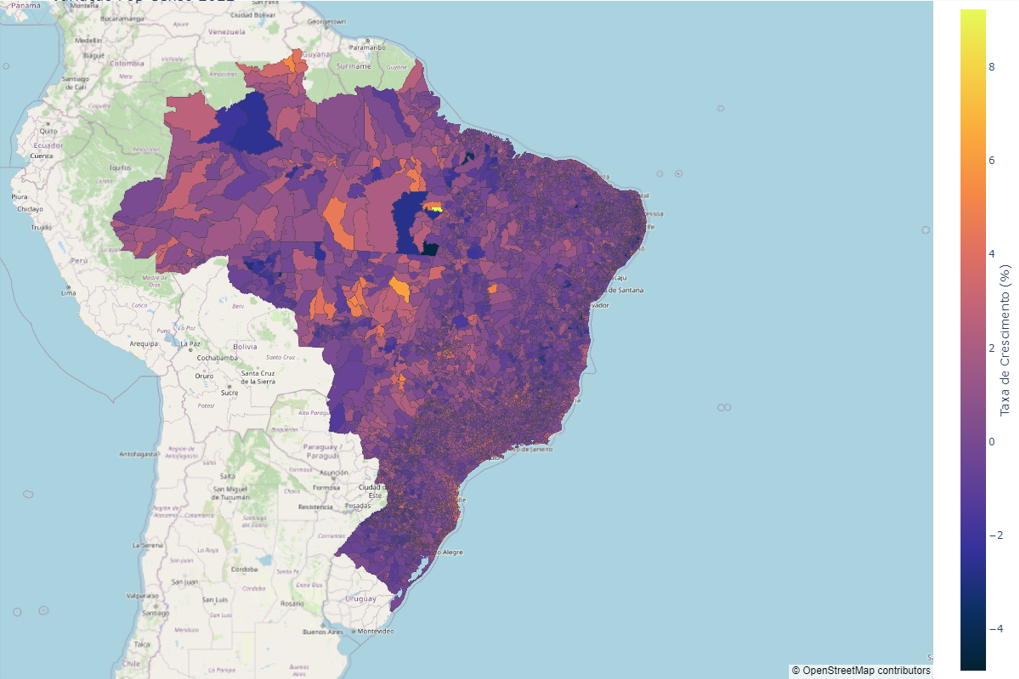